In [180]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import yfinance as yf
%matplotlib inline

In [247]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
# from pandas_datareader.data import DataReader

# from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
company_ticker = ['TSLA']
company_name = ['TESLA']


end = datetime(2022,9,30)
start = datetime(end.year - 1, 9, 29)
company = {}
i = 0
for stock in company_ticker:
    company[stock] = yf.download(stock, start, end)
    company[stock]['company_name'] = company_name[i]
    company[stock]["Date"] = company[stock]["Close"].index
    i +=1

company = pd.concat(company.values(), axis=0)


[*********************100%***********************]  1 of 1 completed


In [249]:
# SAVE STOCK DATA
company.to_csv('TSLA.csv', index=False)

# LOAD STOCK DATA

Stock = pd.read_csv('./TSLA.csv')

df = Stock
df= df.rename(columns={'Close(t)':'Close'})
print(df.tail(30))

           Open        High         Low       Close   Adj Close    Volume   
223  306.000000  306.500000  301.853333  302.869995  302.869995  47500500  \
224  299.000000  300.359985  292.500000  296.666656  296.666656  61395300   
225  291.913330  292.399994  286.296661  289.913330  289.913330  55843200   
226  291.453339  298.826660  287.923340  296.453339  296.453339  63984900   
227  297.563324  303.646667  296.500000  297.096680  297.096680  57259800   
228  302.359985  302.959991  291.600006  296.070007  296.070007  53230000   
229  297.429993  302.000000  287.470001  288.089996  288.089996  57163900   
230  282.829987  287.739990  280.700012  284.820007  284.820007  41864700   
231  287.869995  288.480011  272.649994  277.700012  277.700012  50541800   
232  280.619995  281.250000  271.809998  275.609985  275.609985  52107300   
233  272.579987  277.579987  266.149994  277.160004  277.160004  54287000   
234  281.070007  282.350006  269.079987  270.209991  270.209991  50890100   

In [250]:
tweet_sent_df = pd.read_csv('tesla_sentiment.csv')

def changeDate(date_str):
    return datetime.strptime(date_str, '%m/%d/%y').strftime('%Y-%m-%d')
    
tweet_sent_df["Date"] = tweet_sent_df["Date"].apply(changeDate)
tweet_sent_df["Date"] = tweet_sent_df["Date"].isin(df['Date'])
tweet_sent_df = tweet_sent_df.drop(columns=["Date","Stock Name"])

df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Adj Close'] = df['Adj Close'].astype(float)
df['Volume'] = df['Volume'].astype(float)
df['Open'] = df['Open'].astype(float)
df["positive"] = tweet_sent_df["positive"]
df["negative"] = tweet_sent_df["negative"]
df["compound"] = tweet_sent_df["compound"]

In [251]:

df.set_index('Date', inplace=True)
df.tail(30)

,Open,High,Low,Close,Adj Close,Volume,company_name,positive,negative,compound
Date,,,,,,,,,,
2021-09-29,259.933319,264.500000,256.893341,260.436676,260.436676,62828700.0,TESLA,0.074,0.781,0.9996
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0,TESLA,0.047,0.818,0.9998
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200.0,TESLA,0.044,0.797,0.9999
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900.0,TESLA,0.045,0.814,0.9996
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800.0,TESLA,0.065,0.819,0.9993
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400.0,TESLA,0.091,0.811,0.8997
2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900.0,TESLA,0.085,0.810,0.9913
2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200.0,TESLA,0.090,0.797,0.9955


Closing Price

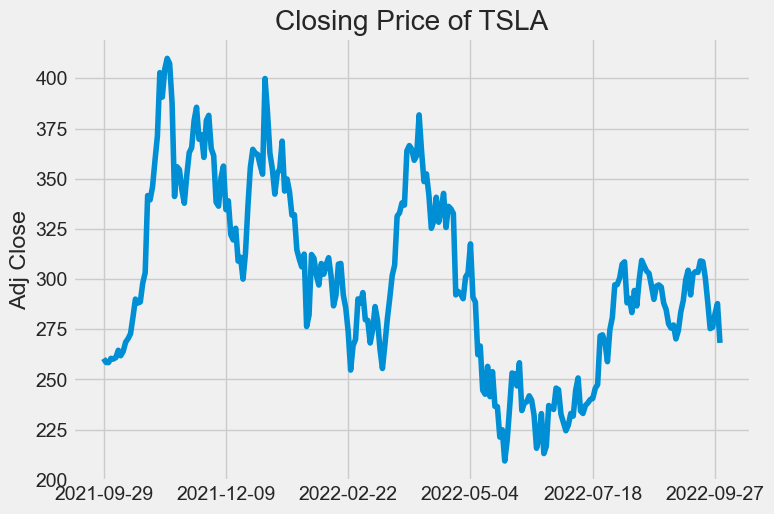

In [252]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_ticker, 1):
    plt.subplot(2, 2, i)
    df['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_ticker[i - 1]}")
    
plt.tight_layout()

<Axes: xlabel='Date'>

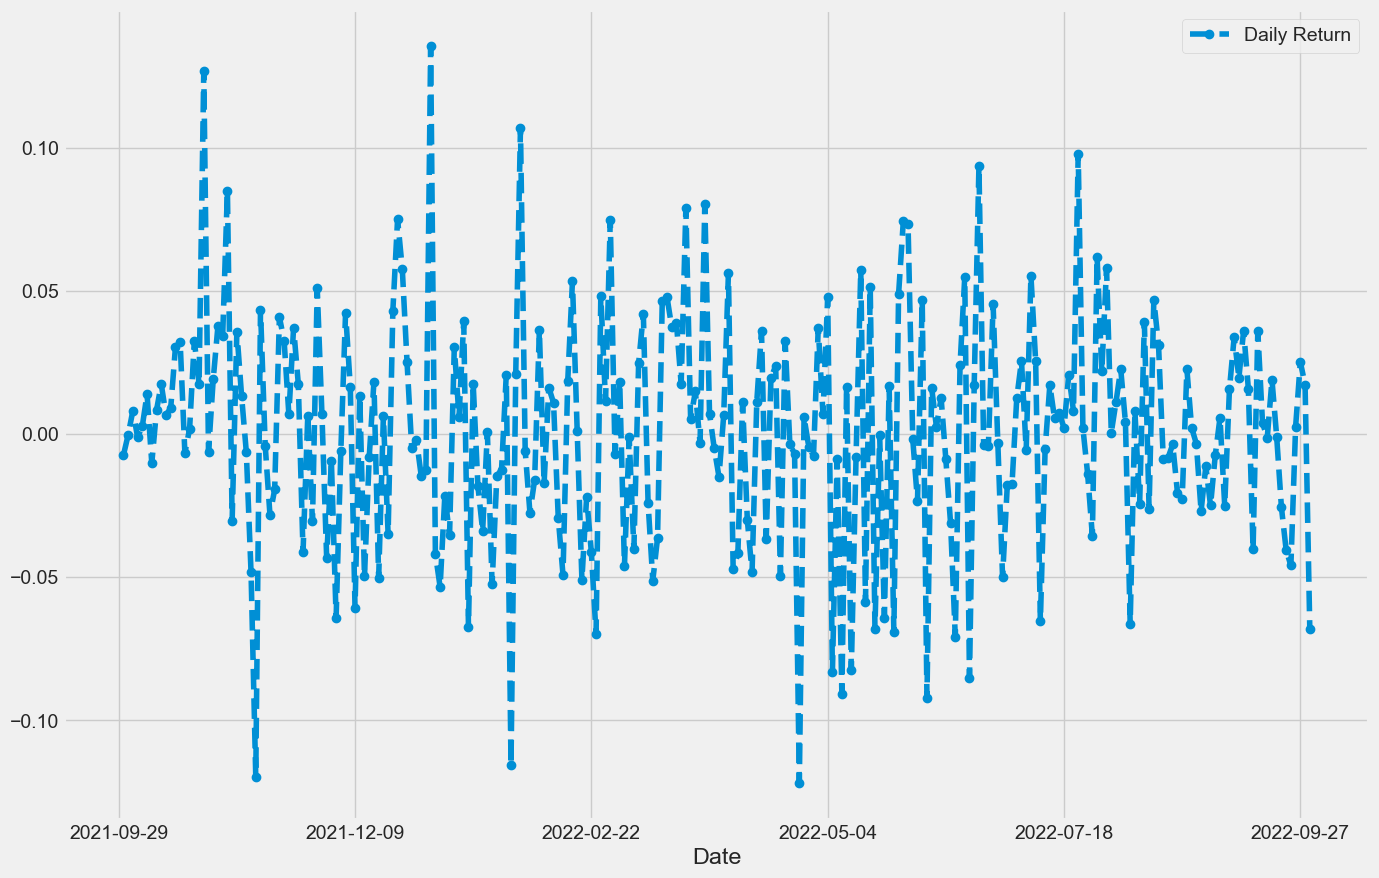

In [253]:
# We'll use pct_change to find the percent change for each day
for company in company_ticker:
    df['Daily Return'] = df['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
plt.figure(figsize=(15, 10))
df['Daily Return'].plot(legend=True, linestyle='--', marker='o')



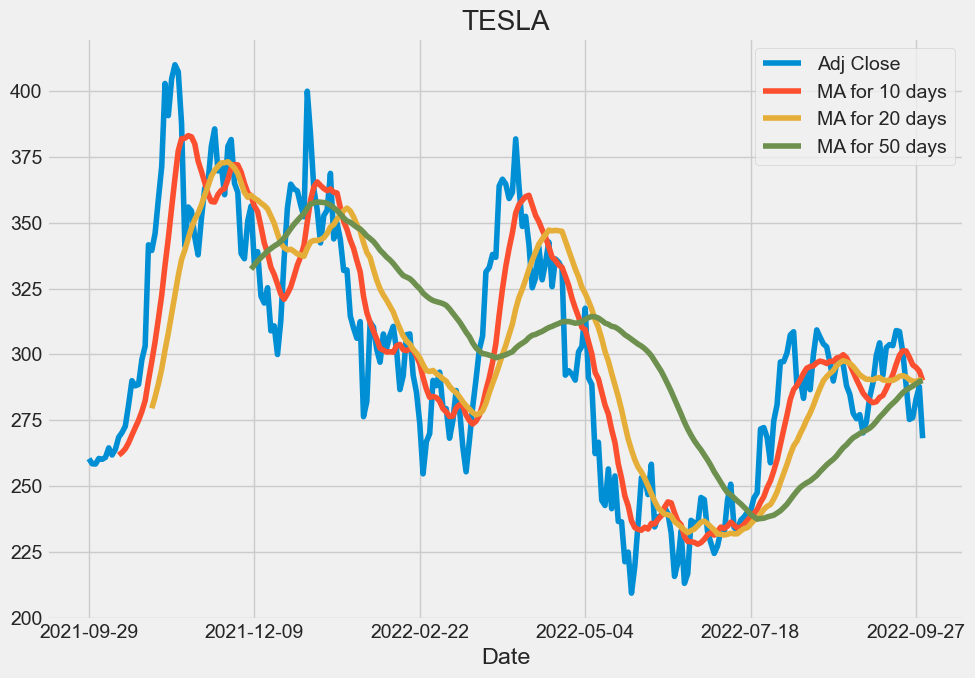

In [254]:
ma_day = [10, 20, 50]
for ma in ma_day:
    for company in company_ticker:
        column_name = f"MA for {ma} days"
        df[column_name] = df['Adj Close'].rolling(ma).mean()
        

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

df[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
ax.set_title('TESLA')

fig.tight_layout()

In [255]:
df = df.drop(columns='Close')
df = df.drop(columns='company_name')
df.iloc[:, :] = df.iloc[:, :].fillna(0)
df

,Open,High,Low,Adj Close,Volume,positive,negative,compound,Daily Return,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,,,,,,,
2021-09-29,259.933319,264.500000,256.893341,260.436676,62828700.0,0.074,0.781,0.9996,0.000000,0.000000,0.000000,0.000000
2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000.0,0.047,0.818,0.9998,-0.007462,0.000000,0.000000,0.000000
2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200.0,0.044,0.797,0.9999,-0.000335,0.000000,0.000000,0.000000
2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900.0,0.045,0.814,0.9996,0.008140,0.000000,0.000000,0.000000
2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800.0,0.065,0.819,0.9993,-0.001203,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,63748400.0,0.091,0.811,0.8997,-0.045948,298.878000,290.471501,287.259467
2022-09-26,271.829987,284.089996,270.309998,276.010010,58076900.0,0.085,0.810,0.9913,0.002470,296.037000,289.867502,287.978334
2022-09-27,283.839996,288.670013,277.510010,282.940002,61925200.0,0.090,0.797,0.9955,0.025108,295.117999,289.773502,288.826201


In [256]:
def create_train_test_set(df_Stock):
    
    features = df_Stock.drop(columns=['Adj Close'], axis=1)
    print(features)
    target = df_Stock['Adj Close']

    data_len = df_Stock.shape[0]
    print('Historical Stock Data length is - ', str(data_len))

    #create a chronological split for train and testing
    train_split = int(data_len * 0.6)
    print('Training Set length - ', str(train_split))

    val_split = train_split + int(data_len * 0.1)
    print('Validation Set length - ', str(int(data_len * 0.2)))

    print('Test Set length - ', str(int(data_len * 0.1)))

    # Splitting features and target into train, validation and test samples 
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    #print shape of samples
    print(X_train.shape, X_val.shape, X_test.shape)
    print(Y_train.shape, Y_val.shape, Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [257]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test_set(df)

                  Open        High         Low      Volume  positive   
Date                                                                   
2021-09-29  259.933319  264.500000  256.893341  62828700.0     0.074  \
2021-09-30  260.333344  263.043335  258.333344  53868000.0     0.047   
2021-10-01  259.466675  260.260010  254.529999  51094200.0     0.044   
2021-10-04  265.500000  268.989990  258.706665  91449900.0     0.045   
2021-10-05  261.600006  265.769989  258.066681  55297800.0     0.065   
...                ...         ...         ...         ...       ...   
2022-09-23  283.089996  284.500000  272.820007  63748400.0     0.091   
2022-09-26  271.829987  284.089996  270.309998  58076900.0     0.085   
2022-09-27  283.839996  288.670013  277.510010  61925200.0     0.090   
2022-09-28  283.079987  289.000000  277.570007  54664800.0     0.070   
2022-09-29  282.760010  283.649994  265.779999  77620600.0     0.044   

            negative  compound  Daily Return  MA for 10 days  M

In [258]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, Y_train)
print('LR Coefficients: \n', lr.coef_)
print('LR Intercept: \n', lr.intercept_)

LR Coefficients: 
 [-1.39343573e-01  4.73836966e-01  6.22370151e-01  3.14771625e-09
 -5.47133858e+01  7.16463825e+00  3.11888661e+00  1.20225679e+02
  7.94680632e-03  1.26483120e-02 -3.59729179e-03]
LR Intercept: 
 3.9176233521773725


### Evaluation

In [259]:
print("Performance (R^2): ", lr.score(X_train, Y_train))

Performance (R^2):  0.9917365127450145


In [260]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [261]:
Y_train_pred = lr.predict(X_train)
Y_val_pred = lr.predict(X_val)
Y_test_pred = lr.predict(X_test)

print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

Training R-squared:  0.99
Training Explained Variation:  0.99
Training MAPE: 0.83
Training Mean Squared Error: 12.47
Training RMSE:  3.53
Training MAE:  2.69
 
Validation R-squared:  0.95
Validation Explained Variation:  0.96
Validation MAPE: 1.38
Validation Mean Squared Error: 12.47
Validation RMSE:  4.26
Validation MAE:  3.37
 
Test R-squared:  0.98
Test Explained Variation:  0.99
Test MAPE: 1.03
Test Mean Squared Error: 13.09
Test RMSE:  3.62
Test MAE:  2.7


In [262]:
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')

### Plot Predicted vs Actual Prices on Time Series plot

<Figure size 1200x10000 with 0 Axes>

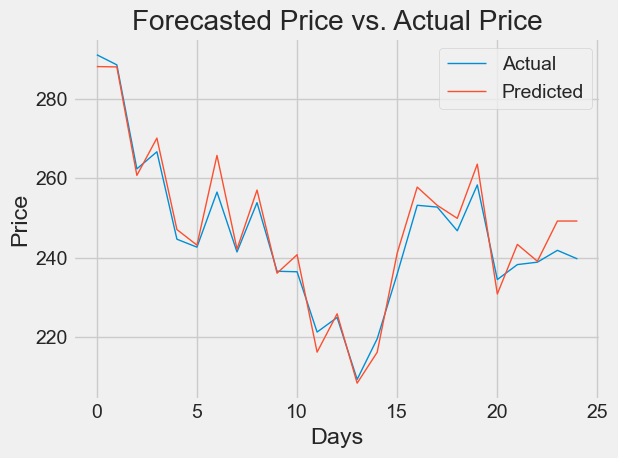

In [263]:
# Set the size of the figure


# Plot your data
fig = plt.figure(figsize=(12,100))

df_pred[['Actual', 'Predicted']].plot(linewidth=1.0)

# Set the x-axis and y-axis labels
plt.xlabel('Days')
plt.ylabel('Price')

# Add a title to the plot
plt.title('Forecasted Price vs. Actual Price')
plt.tight_layout()
plt.style.use('bmh')
plt.grid(True)
# Show the plot
plt.show()

Overall the Predictions looks good for the test data! 